In [1]:
#%config IPCompleter.greedy = True
#%config Completer.use_jedi = False

In [43]:
#Array and Frames Libraries
import pandas as pd
import numpy as np
#Plotting Libraries
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
#Machine Learning Libraries
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.linear_model import GammaRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
#Model Validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
#Normalization
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
#Scoring
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
#Regular Expressions Libraries
import re

In [2]:
#Theme
sns.set_theme(style='darkgrid')

First of all get all data and create a dataframe for them, I have included year, month and day
Next time, i will use some formula for making those calculations

In [83]:
#Data set to train
my_train_file = "./data_v1.xlsx"
data = pd.read_excel(my_train_file)
data

,Date,Program,Visits,Revenue
0,2015-01-01 23:59:59,SEO,0,2317.14
1,2015-01-01 23:59:59,SEO,0,903.10
2,2015-01-01 23:59:59,SEO,2844,0.00
3,2015-01-01 23:59:59,Direct,0,24.31
4,2015-01-01 23:59:59,Direct,937,0.00
...,...,...,...,...
104788,2021-04-11 23:59:59,::unspecified::,14,0.00
104789,2021-04-11 23:59:59,Paid Social,179,0.00
104790,2021-04-11 23:59:59,Organic Social,143,0.00
104791,2021-04-11 23:59:59,Other,1,0.00


In [84]:
#Data set to predict
my_predict_file = "./data_predict_v1.xlsx"
data_predict = pd.read_excel(my_predict_file)
data_predict

,Date,Program,Visits,Revenue
0,2021-04-12 23:59:59,Direct,1,2484.69
1,2021-04-12 23:59:59,Direct,1,1988.53
2,2021-04-12 23:59:59,Direct,1,1984.02
3,2021-04-12 23:59:59,Direct,1,1696.85
4,2021-04-12 23:59:59,Direct,1,1568.62
...,...,...,...,...
1898,2021-05-09 23:59:59,::unspecified::,21,0.00
1899,2021-05-09 23:59:59,Paid Social,1050,0.00
1900,2021-05-09 23:59:59,Organic Social,19,0.00
1901,2021-05-09 23:59:59,Other,4,0.00


In [4]:
#Let's check if there is any NaN
data.isna().sum()

Date       0
Program    0
Visits     0
Revenue    0
dtype: int64

In [5]:
data.dtypes

Date       datetime64[ns]
Program            object
Visits              int64
Revenue           float64
dtype: object

In [6]:
#Lets see the data. We are not going to work with all Programs
#Just SEO, Direct, SEM, Display, Affiliate and Email
#We are going to sum in the Display bucket Paid Social, Organic Social, Lenovo Social, Social
#And the rest will go to the Direct bucket
data.groupby(['Program'])['Visits'].sum().reset_index().sort_values('Visits', ascending=False)

,Program,Visits
14,SEO,10123792
5,Direct,9447233
13,SEM,6433696
6,Display,1754140
1,Affiliate,1145913
11,Paid Social,840522
7,Email,615732
9,Organic Social,108568
4,Company Social,71203
2,Apps,67551


In [7]:
def convert_dates(df, column):
    """
    DESCRIPTION
      This function returns a new DataFrame with a new Year, Month, Day and Year-Week column
    ARGUMENTS
      df: This is the DataFrame to manipulate
      column: The date column name
    RETURN
      A new DataFrame with 4 new columns related to the date
    """
        
    #This is the returned DataFrame
    data = df.copy()
    
    #This function retreives an isocalendar Series
    isocalendar = df[column].apply(lambda x: pd.to_datetime(x).isocalendar())
    #Get all ISO Year Series and ISO Week Series
    year = isocalendar.apply(lambda x: x[0])
    week = isocalendar.apply(lambda x: x[1])
    #Get Month Series and Day Series
    month = df[column].apply(lambda x: pd.to_datetime(x).month)
    day = df[column].apply(lambda x: pd.to_datetime(x).day)
    
    #Add the new columns
    data['Year'] = year
    data['Month'] = month
    data['Day'] = day
    data['Week'] = week
    
    #This creates the Year-Week concatenated Series and it is added to the DataFrame
    year_week = data.apply(lambda x: str(x['Year']) + '-0' + str(x['Week']) if x['Week'] < 10 else str(x['Year']) + '-' + str(x['Week']), axis = 1)
    data['Year-Week'] = year_week
    
    return data

In [8]:
def group_programs(df):
    """
    DESCRIPTION
      This function returns a new DataFrame just keeping the main Programs: Direct, SEO, SEM, Affiliate, Email and Display
    ARGUMENTS
      df: This is the DataFrame to group
    RETURN
      A new DataFrame with inly those Programs
    """
    
    #Create a copy of the DataFrame
    data = df.copy()
    
    #Now, we have two main sets, selected_programs what we want to keep
    #And sub_programs which contain the remaining Programs to merge with two Direct and Display
    all_programs = set(data['Program'].unique())
    selected_programs = set(['Direct', 'SEO', 'SEM', 'Affiliate', 'Email', 'Display'])
    sub_programs = all_programs - selected_programs
    
    #We are going to create two subsets one which will have all Programs to merge with Direct
    #And another one to merge with Display
    new_display = set()
    for i in sub_programs:
        if 'Social' in i:
            new_display.add(i)
    new_direct = sub_programs - new_display
    
    #Just rename all new_direct Programs as Direct and same with Display
    data.loc[(data['Program'].isin(list(new_direct))), 'Program'] = 'Direct'
    data.loc[(data['Program'].isin(list(new_display))), 'Program'] = 'Display'
    
    return data

In [9]:
def get_black_friday_cyber_monday(df):
    """
    DESCRIPTION
      This function returns a new DataFrame with a new Black Friday and Cyber Monday column
    ARGUMENTS
      df: This is the DataFrame with Year and Week columns
    RETURN
      A new DataFrame with 2 new columns
    """
    
    #Create a copy of the DataFrame
    data = df.copy()
    #These are the dictionaries when a Black Friday or Cyber Monday takes place
    bf_dict = {47:[2016, 2017, 2018, 2021],
          48:[2015, 2019, 2020]}
    cm_dict = {48:[2016, 2017, 2018, 2021],
          49:[2015, 2019, 2020]}
    
    data['Black_Friday'] = 0
    data['Cyber_Monday'] = 0
    #
    for week in bf_dict:
        data['Black_Friday'][data['Year'].isin(bf_dict[week]) & (data['Week'] == week)] = 1
    for week in cm_dict:
        data['Cyber_Monday'][data['Year'].isin(cm_dict[week]) & (data['Week'] == week)] = 1
    
    return data

In [10]:
def dataframe_preparation(df):
    """
    DESCRIPTION
      This function returns a new DataFrame with all Columns well sorted and normalized
    ARGUMENTS
      df: This is original DataFrame to manipulate
    RETURN
      A new DataFrame with Xs Values: Year, Week, Black Friday, Cyber Monday, Direct, SEO, SEM, Affiliate, Email, Display and Y Value: Revenue
    """
    
    #Clone the current DataFrame
    data = df.copy()
    #First of all manipulate the Date column and split into Year, Month, Day and Year-Week
    data = convert_dates(data, 'Date')
    
    #Let's keep the columns needed
    #Because we are going to use ISO Week and ISO Year, we are not going to use Month
    data = data[['Year', 'Week', 'Program', 'Visits', 'Revenue']]
    
    #We are not going to work with all Programs, just SEO, Direct, SEM, Display, Affiliate and Email
    #We are going to sum in the Display bucket Paid Social, Organic Social, Lenovo Social and Social
    #And the rest will go to the Direct bucket
    data = group_programs(data)
    
    #Now let's build the Xs - Features. Program for us is similar to Traffic Sources
    program_data = data.groupby(['Year', 'Week', 'Program'])['Visits'].sum().unstack().fillna(value = 0).reset_index()
    #In this phase we need to add two categorial variables - Black Friday and Cyber Monday in this DataFrame
    bf_cm_data = get_black_friday_cyber_monday(program_data.iloc[:,0:2])
    
    #Now let's build the Y - Revenue. We are using as primary key for merging Year and Week
    revenue_data = data.groupby(['Year', 'Week'])['Revenue'].sum().reset_index()
    
    #DataFrame is ready
    return pd.concat([bf_cm_data, 
                      program_data[['Direct', 'SEO', 'SEM', 'Affiliate', 'Email', 'Display']], 
                      revenue_data['Revenue']], axis = 1)

In [11]:
def data_preparation(df, X_params, y_params):
    """
    DESCRIPTION
      This function returns a X Pandas set for splitting or predict and Y Series for splitting or predict
    ARGUMENTS
      df: This is the DataFrame from get train and test data
      X_params: It is the list with the features
      y: It is objective to analyze. It is the dependant variable
    RETURN
      A new DataFrame with Xs Values: Year, Week, Black Friday, Cyber Monday, Direct, SEO, SEM, Affiliate, Email, Display
      and Y Value: Revenue
    """
    
    X = df[X_params] # pandas DataFrame
    y = df[y_params] # pandas Series
    
    return X, y

In [12]:
def data_split(X, y):
    """
    DESCRIPTION
      This function returns the set for training and test
    ARGUMENTS
      X: It is a DataFrame with the features
      y: It is a Series with the objective
    RETURN
      The X Train and Test and y Train and Test
    """
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
    return X_train, X_test, y_train, y_test

In [15]:
def data_normalization(df, scale_param):
    """
    DESCRIPTION
      This function returns a new DataFrame with all elements normalized based on scale method
    ARGUMENTS
      df: DataFrame to normalize
      scaler: Type of normalization
    RETURN
      New DataFrame normalized
    """
    
    #Dictionaries of scaling methods
    methods = {'norm': StandardScaler(),
               'robust': RobustScaler()}
    #Data Normalization
    scaler = methods[scale_param]
    columns = df.columns
    return pd.DataFrame(scaler.fit_transform(df), columns = columns)

In [150]:
def draw_predict(model, X_real, y_real):
    """
    DESCRIPTION
      This plot real values versus predicted values
    ARGUMENTS
      model: Regression model to apply predict
      X_real: Real features
      y_real: Real objective or dependant variable
    RETURN
      Draw a plot
    """
    
    #Get the predictions
    y_pred = model.predict(X_real)
    print(f'{type(model).__name__} | Predict MAE: {mean_absolute_error(y_real,y_pred):.4f}')
    print(f'{type(model).__name__} | Predict RMSE: {np.sqrt(mean_squared_error(y_real,y_pred)):.4f}')
    print(f'{type(model).__name__} | Predict R2: {r2_score(y_real,y_pred):.4f}')
    
    #Plot the real Ys versus Y predicted
    fig = plt.figure()
    fig.set_size_inches(20,10)
    plt.plot(range(X_real.iloc[:,0].count()), y_real)
    plt.plot(range(X_real.iloc[:,0].count()), y_pred, c='r', linewidth=3)

In [62]:
#data.columns[0:-1] #todas las columnas menos la última
#data.columns[-1] #solo la última columna

In [85]:
data = dataframe_preparation(data)
data_predict = dataframe_preparation(data_predict)

In [94]:
full_data = pd.concat([data, data_predict], ignore_index = True)

LinearRegression | Predict MAE: 55498.1839
LinearRegression | Predict RMSE: 65743.6040
LinearRegression | Predict R2: -1.2317
RandomForestRegressor | Predict MAE: 44151.6723
RandomForestRegressor | Predict RMSE: 46977.3018
RandomForestRegressor | Predict R2: -0.1395
XGBRegressor | Predict MAE: 57583.6434
XGBRegressor | Predict RMSE: 69794.2914
XGBRegressor | Predict R2: -1.5152
LGBMRegressor | Predict MAE: 49326.6867
LGBMRegressor | Predict RMSE: 60300.0933
LGBMRegressor | Predict R2: -0.8775


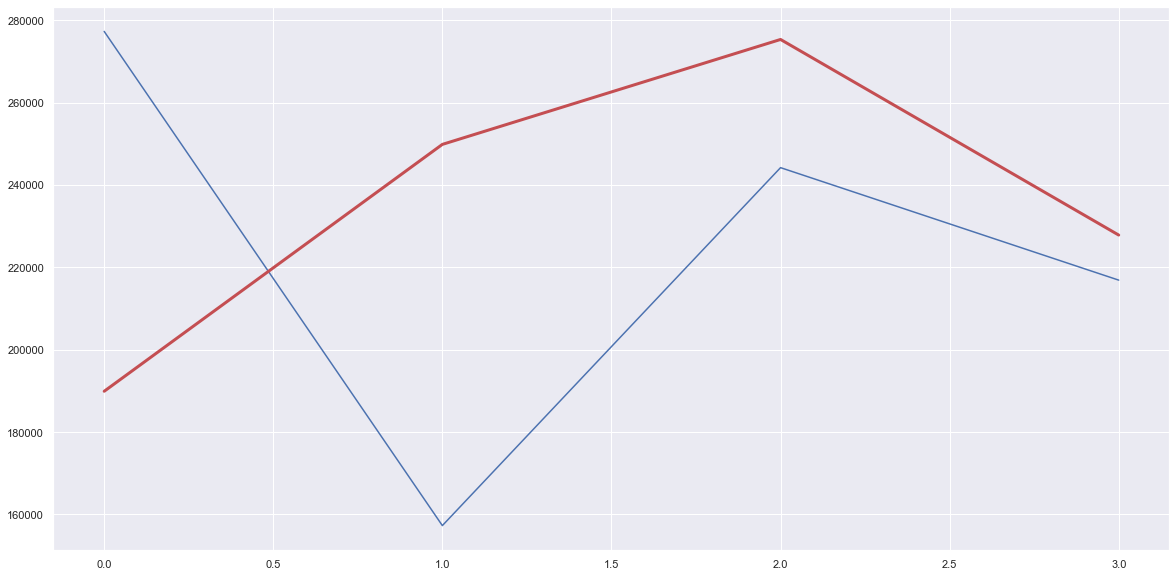

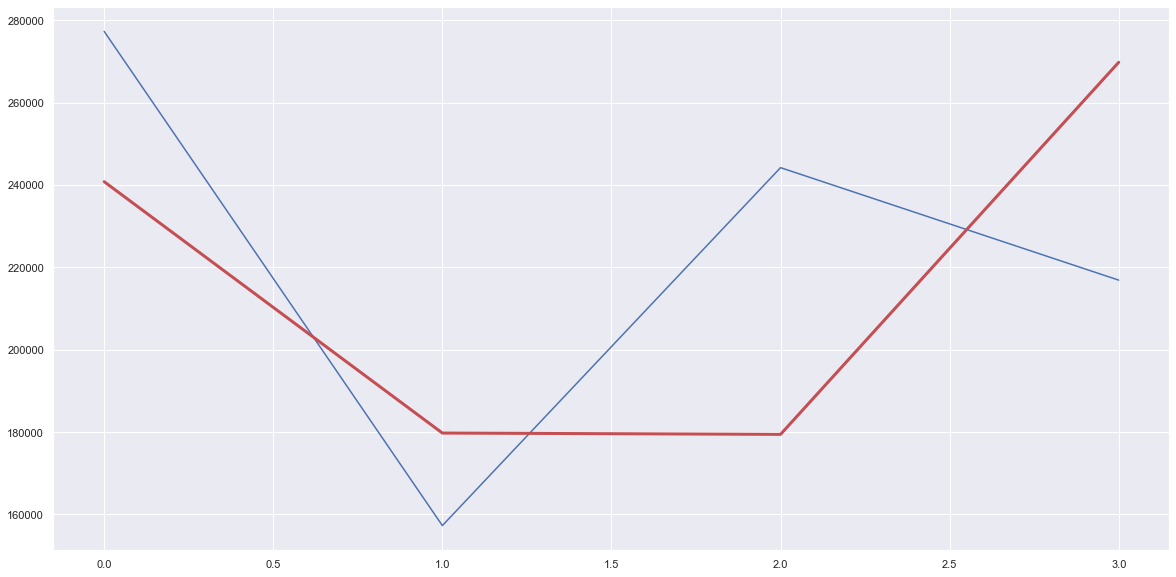

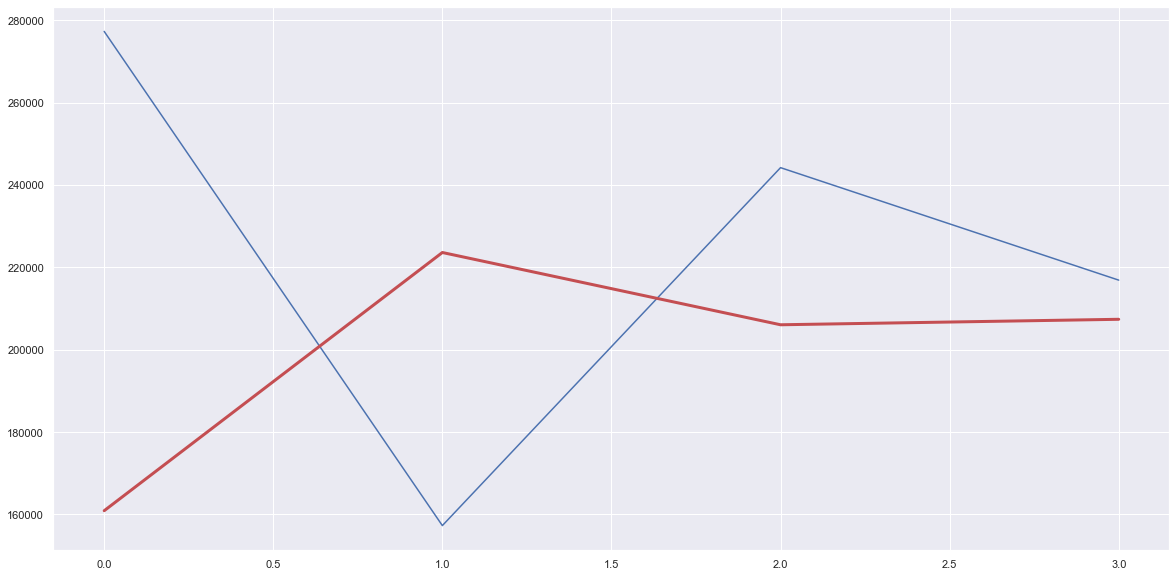

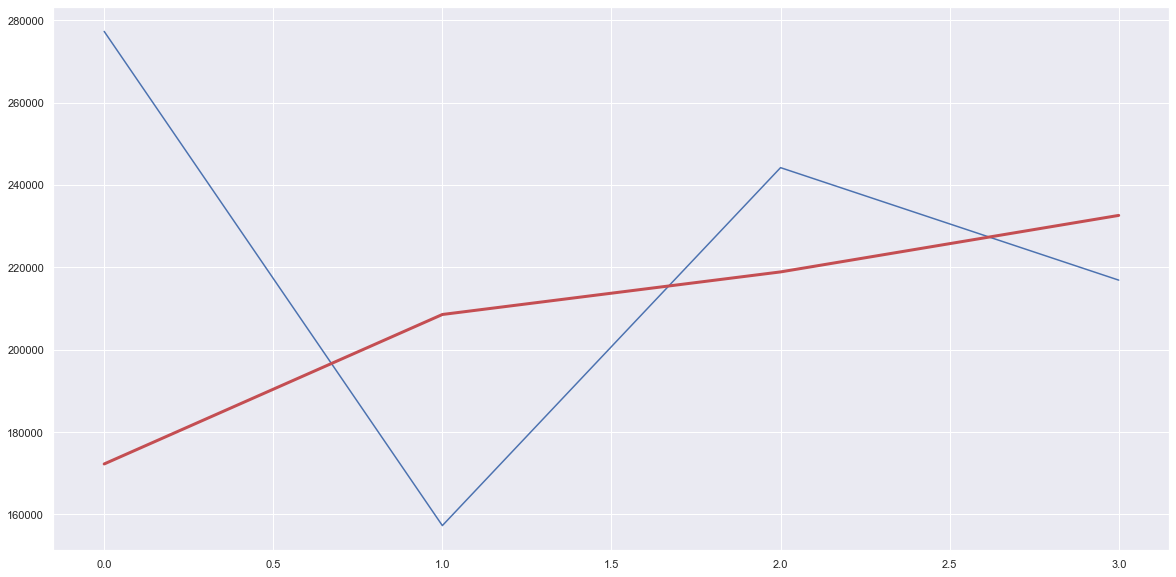

In [151]:
#model = [LR, RFR, XGB, LGBM]
model = [LR, RFR, XGB, LGBM]
for i in model:
    draw_predict(i, X_small, y_small)
    #draw_predict(i, X_full, y_full)

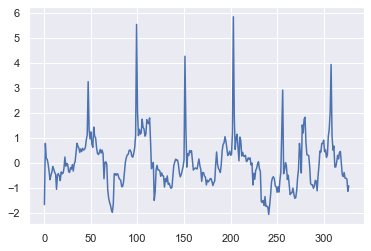

In [147]:
plt.plot(data_normalization(data, 'norm').index, data_normalization(data, 'norm')['SEO'])

In [148]:
data_normalization(data, 'norm2')['Revenue'].describe()

count    328.000000
mean       0.922681
std        0.077671
min        0.395655
25%        0.899060
50%        0.949423
75%        0.975245
max        0.996721
Name: Revenue, dtype: float64

(array([  1.,   1.,   0.,   1.,   3.,   5.,  21.,  30.,  72., 194.]),
 array([0.39565462, 0.45576129, 0.51586795, 0.57597462, 0.63608129,
        0.69618796, 0.75629462, 0.81640129, 0.87650796, 0.93661463,
        0.9967213 ]),
 <BarContainer object of 10 artists>)

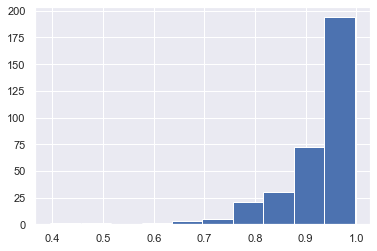

In [151]:
plt.hist(data_normalization(data, 'norm2')['Revenue'] )#bins=np.linspace(start=-2,stop=8,num=90)
#plt.plot(data_normalization(data, 'norm').index, data_normalization(data, 'norm')['SEM'])

In [66]:
data.apply(np.log1p)

,Year,Week,Black_Friday,Cyber_Monday,Direct,SEO,SEM,Affiliate,Email,Display,Revenue
0,7.608871,0.693147,0.0,0.0,8.464847,9.665167,0.000000,3.218876,4.672829,0.000000,9.150649
1,7.608871,1.098612,0.0,0.0,9.384126,10.542390,8.913550,3.583519,5.545177,0.000000,9.765821
2,7.608871,1.386294,0.0,0.0,9.148039,10.388226,9.134754,3.258097,7.939515,0.000000,10.542066
3,7.608871,1.609438,0.0,0.0,9.414097,10.376705,9.062072,2.944439,5.913503,0.000000,10.841218
4,7.608871,1.791759,0.0,0.0,9.316501,10.322066,8.997271,3.713572,5.398163,0.000000,10.241253
...,...,...,...,...,...,...,...,...,...,...,...
323,7.611842,2.397895,0.0,0.0,11.568455,10.139152,10.046462,9.134107,7.636270,10.329213,12.318878
324,7.611842,2.484907,0.0,0.0,11.721329,10.136898,9.855190,8.593784,7.400010,10.455302,12.397084
325,7.611842,2.564949,0.0,0.0,11.976395,10.124749,9.722086,8.597113,7.311218,10.413523,12.197604
326,7.611842,2.639057,0.0,0.0,11.588636,9.930859,9.567035,7.959975,7.555382,9.665357,11.860825


In [64]:
data_normalization(data)

,Year,Week,Black_Friday,Cyber_Monday,Direct,SEO,SEM,Affiliate,Email,Display,Revenue
0,-1.455566,-1.623756,-0.136505,-0.136505,-0.732722,-1.669129,-1.614310,-0.629234,-1.144895,-0.663275,-0.969425
1,-1.455566,-1.558415,-0.136505,-0.136505,-0.518005,0.775805,-1.002738,-0.627239,-1.048583,-0.663275,-0.923885
2,-1.455566,-1.493075,-0.136505,-0.136505,-0.593110,0.177747,-0.851306,-0.629053,0.599694,-0.663275,-0.807590
3,-1.455566,-1.427734,-0.136505,-0.136505,-0.507139,0.136646,-0.904801,-0.630322,-0.974896,-0.663275,-0.732472
4,-1.455566,-1.362393,-0.136505,-0.136505,-0.541359,-0.051952,-0.949325,-0.626332,-1.071207,-0.663275,-0.863551
...,...,...,...,...,...,...,...,...,...,...,...
323,1.840814,-1.035690,-0.136505,-0.136505,2.298016,-0.613329,0.284600,1.046662,0.125249,1.737207,0.250300
324,1.840814,-0.970349,-0.136505,-0.136505,2.822155,-0.619627,-0.046000,0.345183,-0.156575,2.059802,0.353876
325,1.840814,-0.905008,-0.136505,-0.136505,3.896398,-0.653325,-0.241462,0.348448,-0.246422,1.948376,0.104877
326,1.840814,-0.839668,-0.136505,-0.136505,2.362704,-1.139240,-0.438653,-0.114369,0.021181,0.572605,-0.217621


In [13]:
data.describe()

,Year,Week,Black_Friday,Cyber_Monday,Direct,SEO,SEM,Affiliate,Email,Display,Revenue
count,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000,3.280000e+02
mean,2017.649390,25.850610,0.018293,0.018293,29153.661585,30865.219512,19614.926829,3493.637195,1877.231707,8458.652439,1.798721e+05
std,1.822959,15.327783,0.134212,0.134212,33364.571361,9064.790858,12169.224540,5522.490739,1549.433410,12772.337295,1.760972e+05
min,2015.000000,1.000000,0.000000,0.000000,4744.000000,12200.000000,0.000000,5.000000,80.000000,0.000000,9.419550e+03
25%,2016.000000,12.000000,0.000000,0.000000,10159.750000,25354.500000,11729.750000,685.000000,949.500000,415.500000,8.729839e+04
50%,2018.000000,25.500000,0.000000,0.000000,12257.500000,29937.000000,17840.500000,1605.500000,1468.500000,2795.000000,1.465062e+05
75%,2019.000000,39.000000,0.000000,0.000000,43434.250000,35060.250000,23354.000000,4160.500000,2347.250000,12024.000000,2.255418e+05
max,2021.000000,53.000000,1.000000,1.000000,183505.000000,83666.000000,107992.000000,58734.000000,12566.000000,72378.000000,1.698646e+06


<AxesSubplot:>

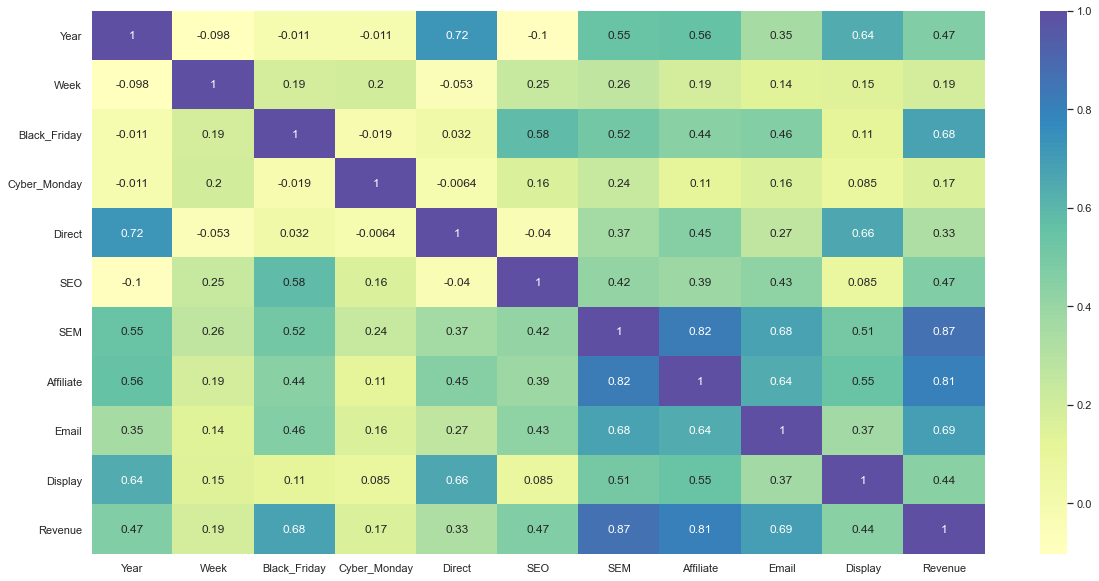

In [18]:
corr = data.corr()
fig = plt.figure()
fig.set_size_inches(20,10)
#Otra manera
#plt.subplots(figsize=(20, 10))
sns.heatmap(corr, cmap='Spectral', annot=True, center=-0.1)

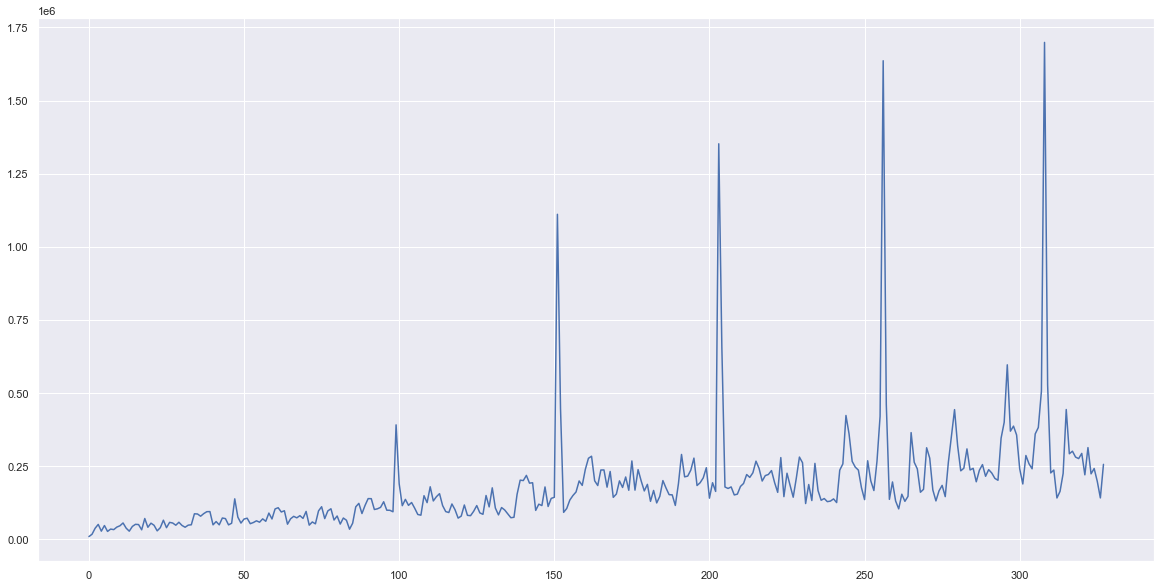

In [15]:
fig = plt.figure()
fig.set_size_inches(20,10)
plt.plot(data.index, data['Revenue'])

'LinearRegression'

In [89]:
#X_params = ['Year', 'Week', 'Black_Friday', 'Cyber_Monday', 'Direct', 'SEO', 'SEM', 'Affiliate', 'Email', 'Display']
#y_params = 'Revenue'
X_train, X_test, y_train, y_test = data_split(*data_preparation(data, data.columns[0:-1], data.columns[-1]))

In [100]:
X_full, y_full = data_preparation(full_data, full_data.columns[0:-1], full_data.columns[-1])
X_small, y_small = data_preparation(data_predict, data_predict.columns[0:-1], data_predict.columns[-1])

In [61]:
LR = LinearRegression()
LR.fit(X_train,y_train)

print('Train set mse:', mean_squared_error(y_train, LR.predict(X_train)))
print('Test set mse:', mean_squared_error(y_test, LR.predict(X_test)))
print('Test set score:', LR.score(X_test,y_test))

Train set mse: 4215695243.864121
Test set mse: 4735497127.684606
Test set score: 0.896752113645494


In [75]:
RFR = RandomForestRegressor(n_estimators = 100, criterion = 'mae', bootstrap = False)
RFR.fit(X_train,y_train)

print('Train set mse:', mean_squared_error(y_train, RFR.predict(X_train)))
print('Test set mse:', mean_squared_error(y_test, RFR.predict(X_test)))
print('Test set score:', RFR.score(X_test,y_test))

Train set mse: 1.3856101178004603e-19
Test set mse: 4584620053.390801
Test set score: 0.9000416814775842


<AxesSubplot:>

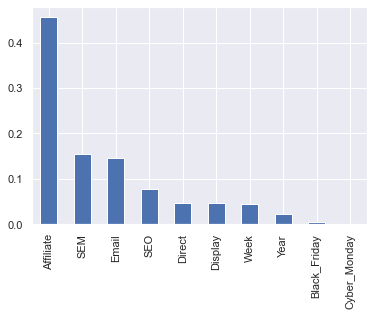

In [76]:
pd.Series(RFR.feature_importances_, data.columns[0:-1]).sort_values(ascending = False).plot(kind = 'bar')

In [63]:
XGB = XGBRegressor(max_depth=16,n_estimators=200,seed=1)
XGB.fit(X_train,y_train)

print('Train set mse:', mean_squared_error(y_train, XGB.predict(X_train)))
print('Test set mse:', mean_squared_error(y_test, XGB.predict(X_test)))
print('Test set score:', XGB.score(X_test,y_test))

Train set mse: 0.001396040080085938
Test set mse: 2685596952.4236803
Test set score: 0.9414460189793372


<AxesSubplot:>

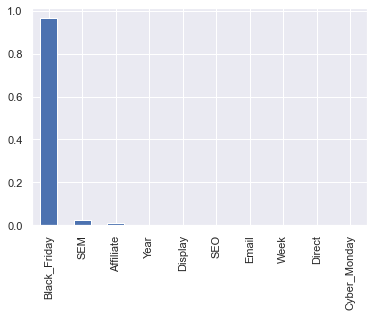

In [38]:
pd.Series(XGB.feature_importances_, data.columns[0:-1]).sort_values(ascending = False).plot(kind = 'bar')

In [64]:
LGBM = LGBMRegressor(max_depth=16,num_leaves=2048, n_estimators=200,seed=1)
LGBM.fit(X_train,y_train)
y_pred = LGBM.predict(X_test)

print('Train set mse:', mean_squared_error(y_train, LGBM.predict(X_train)))
print('Test set mse:', mean_squared_error(y_test, LGBM.predict(X_test)))
print('Test set score:', LGBM.score(X_test,y_test))

Train set mse: 2233988496.4294353
Test set mse: 15791596451.992142
Test set score: 0.6556963478449616


<AxesSubplot:>

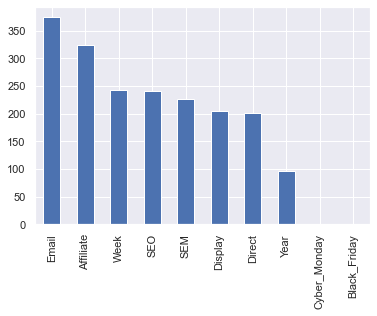

In [37]:
pd.Series(LGBM.feature_importances_, data.columns[0:-1]).sort_values(ascending = False).plot(kind = 'bar')

In [122]:
y_pred2 = LR.predict(X_full)

In [123]:
mean_absolute_error(y_full,y_pred2)

42100.98692506857

In [124]:
r2_score(y_full, y_pred2)

0.8587654972822847

In [ ]:
r2_score()

In [41]:
#LR RFR, XGB, LGBM
y_pred2 = RFR.predict(X_full)
print("MAE:", mean_absolute_error(y_full,y_pred2))
print("R2: ", r2_score(y_full, y_pred2))
fig = plt.figure()
fig.set_size_inches(20,10)
plt.plot(range(X_full['Year'].count()), y_full)
plt.plot(range(X_full['Year'].count()), y_pred2, c='r', linewidth=3)

NameError: name 'X_full' is not defined

MAE: 49326.68668070354
R2:  -0.8774535528101521


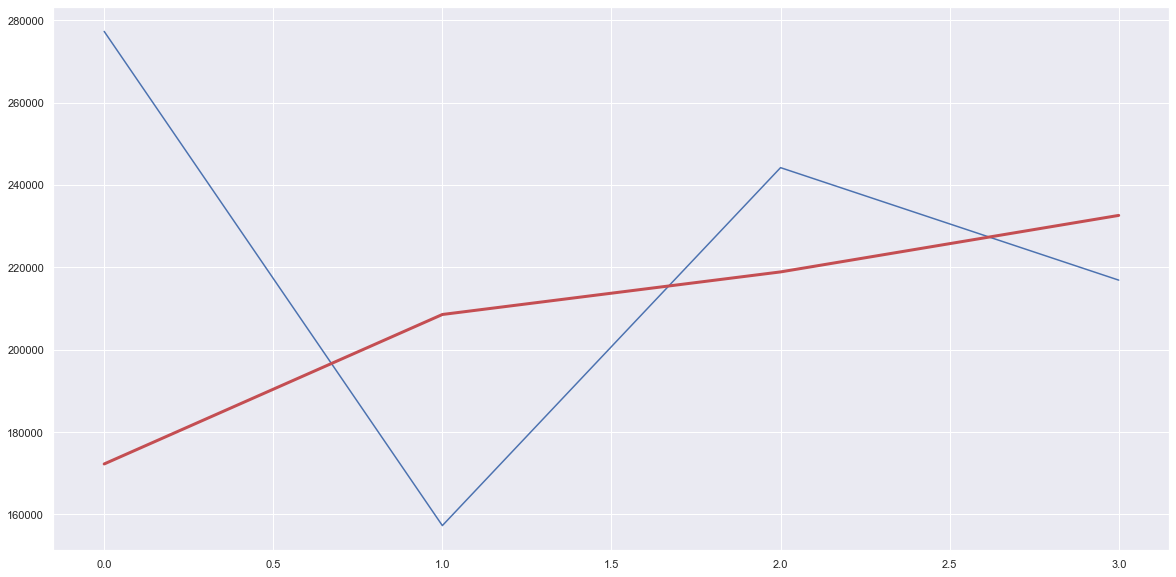

In [49]:
#LR RFR, XGB, LGBM
y_pred2 = LGBM.predict(X_small)
print("MAE:", mean_absolute_error(y_small,y_pred2))
print("R2: ", r2_score(y_small, y_pred2))
fig = plt.figure()
fig.set_size_inches(20,10)
plt.plot(range(X_small['Year'].count()), y_small)
plt.plot(range(X_small['Year'].count()), y_pred2, c='r', linewidth=3)

In [237]:
#Data Contraction via Log
data_log1p = data_consolidated.apply(np.log1p)
data_log1p

,Year,Week,Black_Friday,Cyber_Monday,Affiliate,Direct,Display,Email,SEM,SEO,Revenue
0,7.608871,0.693147,0.0,0.0,3.218876,8.464847,0.000000,4.672829,0.000000,9.665167,9.150649
1,7.608871,1.098612,0.0,0.0,3.583519,9.384126,0.000000,5.545177,8.913550,10.542390,9.765821
2,7.608871,1.386294,0.0,0.0,3.258097,9.148039,0.000000,7.939515,9.134754,10.388226,10.542066
3,7.608871,1.609438,0.0,0.0,2.944439,9.414097,0.000000,5.913503,9.062072,10.376705,10.841218
4,7.608871,1.791759,0.0,0.0,3.713572,9.316501,0.000000,5.398163,8.997271,10.322066,10.241253
...,...,...,...,...,...,...,...,...,...,...,...
323,7.611842,2.397895,0.0,0.0,9.134107,11.568455,10.329213,7.636270,10.046462,10.139152,12.318878
324,7.611842,2.484907,0.0,0.0,8.593784,11.721329,10.455302,7.400010,9.855190,10.136898,12.397084
325,7.611842,2.564949,0.0,0.0,8.597113,11.976395,10.413523,7.311218,9.722086,10.124749,12.197604
326,7.611842,2.639057,0.0,0.0,7.959975,11.588636,9.665357,7.555382,9.567035,9.930859,11.860825


<AxesSubplot:>

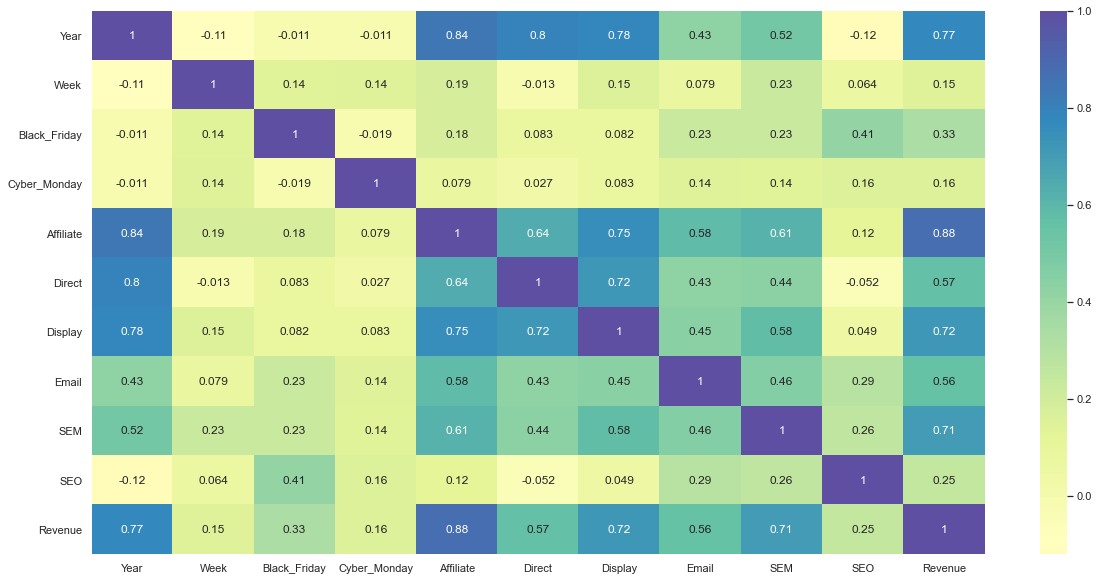

In [238]:
corr = data_log1p.corr()
fig = plt.figure()
fig.set_size_inches(20,10)
#Otra manera
#plt.subplots(figsize=(20, 10))
sns.heatmap(corr, cmap='Spectral', annot=True, center=-0.1)

In [215]:
#Data Normalization
scaler = StandardScaler()
columns = ['Year', 'Week', 'Black_Friday', 'Cyber_Monday', 'Direct', 
           'SEO', 'SEM', 'Affiliate', 'Email', 'Display', 'Revenue']
data_scaled = pd.DataFrame(scaler.fit_transform(data_consolidated), columns = columns)

In [286]:
# Data Preparation
X = data_log1p[['Year', 'Week', 'Black_Friday', 'Cyber_Monday', 'Direct', 
                       'SEO', 'SEM', 'Affiliate', 'Email', 'Display']] # pandas DataFrame
y = data_log1p['Revenue'] # pandas Series

In [287]:
#Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [116]:
#Regresión Linear

In [397]:
#Regression
reg = LinearRegression()
#Train the model
reg.fit(X_train,y_train)

LinearRegression()

In [398]:
y_pred = reg.predict(X_test)

In [419]:
mean_absolute_error(y_test,y_pred) # Primero valor real y luego prediccion

47077.8999167806

In [420]:
np.sqrt(mean_squared_error(y_test, y_pred))

75948.39333726655

In [479]:
r2_score(y_test, y_pred)

0.874237033174075

In [477]:
#@@@@@@@@@@@@@@@@@@@#

In [478]:
np.mean(reg.predict(X_test)-y_test)

-1820.193607547661

In [493]:
np.corrcoef?

In [484]:
np.corrcoef(reg.predict(X_test),y_test)[0][1]

0.935078279941874

In [489]:
def corr(pred,y_test):
    return np.corrcoef(pred,y_test)[0][1]

def bias(pred,y_test):
    return np.mean(pred-y_test)

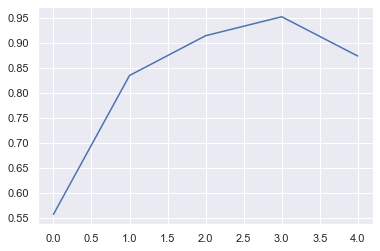

In [495]:
variance = cross_val_score(reg,X,y,cv=5,scoring=make_scorer(corr))
biass = cross_val_score(reg,X,y,cv=5,scoring=make_scorer(bias))
plt.plot(range(len(variance)), variance)

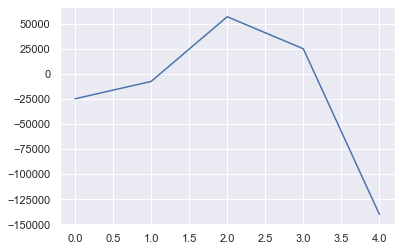

In [494]:
plt.plot(range(len(biass)), biass)

In [497]:
variance = cross_val_score(reg,X,y,cv=5,scoring=make_scorer(corr)).mean()
biass = cross_val_score(reg,X,y,cv=5,scoring=make_scorer(bias)).mean()
variance, biass

(0.8260367383814634, -18259.63031815729)

In [466]:
res = cross_val_score(reg,X,y,cv=5,scoring='neg_mean_absolute_error')
res

array([ -29321.53262093,  -28152.96301003,  -63976.55642234,
        -59183.99112095, -221019.81877881])

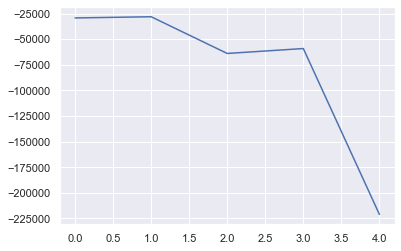

In [467]:
plt.plot(range(len(res)), res)

In [ ]:
#Regresión Gamma

In [123]:
#Regression
reg = GammaRegressor()
#Train the model
reg.fit(X_train,y_train)

/home/dsc/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/link.py:90: RuntimeWarning: overflow encountered in exp
  return np.exp(lin_pred)
/home/dsc/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_glm/link.py:93: RuntimeWarning: overflow encountered in exp
  return np.exp(lin_pred)
/home/dsc/anaconda3/lib/python3.8/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: invalid value encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)


GammaRegressor()

In [124]:
y_pred = reg.predict(X_test)

In [125]:
mean_absolute_error(y_test,y_pred) # Primero valor real y luego prediccion

97592.02979777157

In [126]:
np.sqrt(mean_squared_error(y_test, y_pred))

131120.8514649113

In [127]:
r2_score(y_test, y_pred)

-0.008288885574373905

In [ ]:
#K-Vecinos

In [246]:
#K-Neighbors
regk = KNeighborsRegressor(n_neighbors=10)
#Train the model
regk.fit(X_train,y_train)

KNeighborsRegressor(n_neighbors=10)

In [248]:
y_pred = regk.predict(X_test)

In [249]:
mean_absolute_error(y_test,y_pred) # Primero valor real y luego prediccion

0.23710276867609345

In [250]:
np.sqrt(mean_squared_error(y_test, y_pred))

0.2944816763478674

In [418]:
r2_score(y_test, y_pred)

0.874237033174075

In [36]:
range(X_test['Year'].count())

range(0, 66)

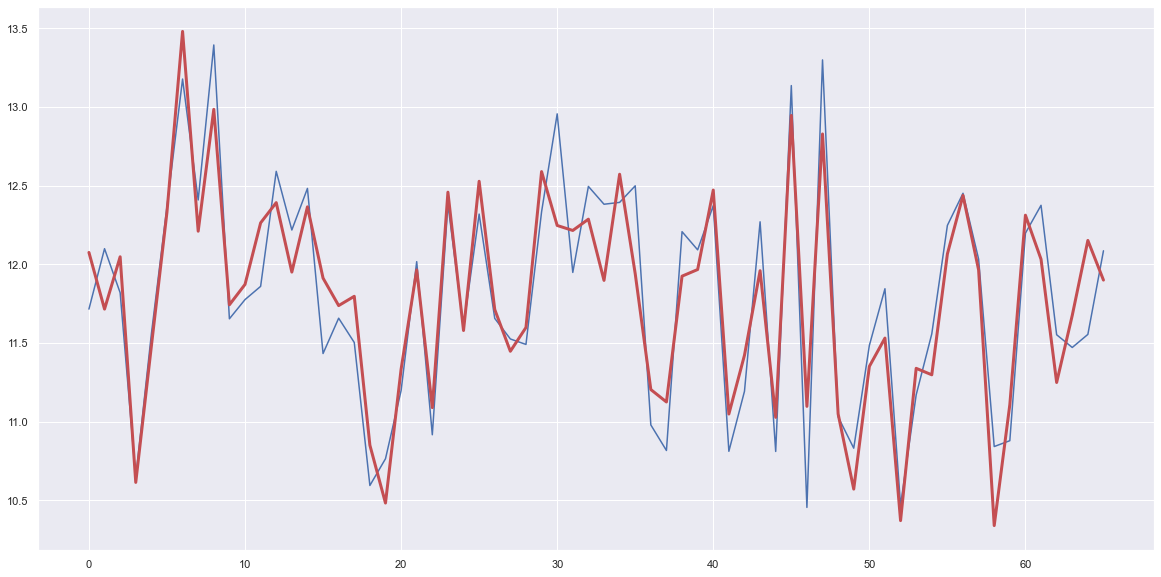

In [293]:
fig = plt.figure()
fig.set_size_inches(20,10)
plt.plot(range(X_test['Year'].count()), y_test)
plt.plot(range(X_test['Year'].count()), y_pred, c='r', linewidth=3)

In [29]:
myfile = "./data_predict_v1.xlsx"
data_predict = pd.read_excel(myfile)
data_predict

,Date,Program,Visits,Revenue
0,2021-04-12 23:59:59,Direct,1,2484.69
1,2021-04-12 23:59:59,Direct,1,1988.53
2,2021-04-12 23:59:59,Direct,1,1984.02
3,2021-04-12 23:59:59,Direct,1,1696.85
4,2021-04-12 23:59:59,Direct,1,1568.62
...,...,...,...,...
1898,2021-05-09 23:59:59,::unspecified::,21,0.00
1899,2021-05-09 23:59:59,Paid Social,1050,0.00
1900,2021-05-09 23:59:59,Organic Social,19,0.00
1901,2021-05-09 23:59:59,Other,4,0.00


In [28]:
data_predict.isna().sum()
data_predict.dtypes

Date       datetime64[ns]
Program            object
Visits              int64
Revenue           float64
dtype: object

In [30]:
data_predict = convert_dates(data_predict, 'Date')
data_predict = data_predict[['Year', 'Week', 'Program', 'Visits', 'Revenue']]

data_predict = group_programs(data_predict)

program_data_predict = data_predict.groupby(['Year', 'Week', 'Program'])['Visits'].sum().unstack().fillna(value = 0).reset_index()
black_friday_and_cyber_monday_data_predict = get_black_friday_cyber_monday(program_data_predict.iloc[:,0:2])
program_data_predict = pd.merge(black_friday_and_cyber_monday_data_predict, program_data_predict)
data_revenue_predict = data_predict.groupby(['Year', 'Week'])['Revenue'].sum().reset_index()
data_consolidated_predict = pd.concat([program_data_predict, data_revenue_predict['Revenue']], axis = 1)
data_consolidated_predict = data_consolidated_predict[['Year', 'Week', 'Black_Friday', 'Cyber_Monday', 'Direct', 
                       'SEO', 'SEM', 'Affiliate', 'Email', 'Display', 'Revenue']]
program_data_predict = program_data_predict[['Year', 'Week', 'Black_Friday', 'Cyber_Monday', 'Direct', 
                       'SEO', 'SEM', 'Affiliate', 'Email', 'Display']]

In [30]:
data_consolidated_predict

,Year,Week,Black_Friday,Cyber_Monday,Direct,SEO,SEM,Affiliate,Email,Display,Revenue
0,2021,15,0,0,101202,23086,21137,3261,1658,12494,277288.61
1,2021,16,0,0,68401,22761,27275,3146,2127,22512,157303.90
2,2021,17,0,0,39055,23616,28314,3832,2196,21476,244209.96
3,2021,18,0,0,31535,21298,20369,3597,2197,17004,216899.81


In [296]:
data_consolidated_predict = data_consolidated_predict.apply(np.log1p)
data_consolidated_predict

,Year,Week,Black_Friday,Cyber_Monday,Direct,SEO,SEM,Affiliate,Email,Display,Revenue
0,7.611842,2.772589,0.0,0.0,11.524884,10.047025,9.958828,8.090096,7.413970,9.433084,12.532818
1,7.611842,2.833213,0.0,0.0,11.133157,10.032848,10.213762,8.054205,7.662938,10.021848,11.965941
2,7.611842,2.890372,0.0,0.0,10.572752,10.069722,10.251147,8.251403,7.694848,9.974738,12.405788
3,7.611842,2.944439,0.0,0.0,10.358885,9.966415,9.921819,8.188133,7.695303,9.741263,12.287195


In [297]:
X_pred = data_consolidated_predict[['Year', 'Week', 'Black_Friday', 'Cyber_Monday', 'Direct', 
                       'SEO', 'SEM', 'Affiliate', 'Email', 'Display']] # pandas DataFrame
y_pred = data_consolidated_predict['Revenue'] # pandas Series

In [298]:
y_pred2 = reg.predict(X_pred)

In [299]:
mean_absolute_error(y_pred,y_pred2)

0.2862432021624479

In [301]:
r2_score(y_pred, y_pred2)

-1.160803420425459

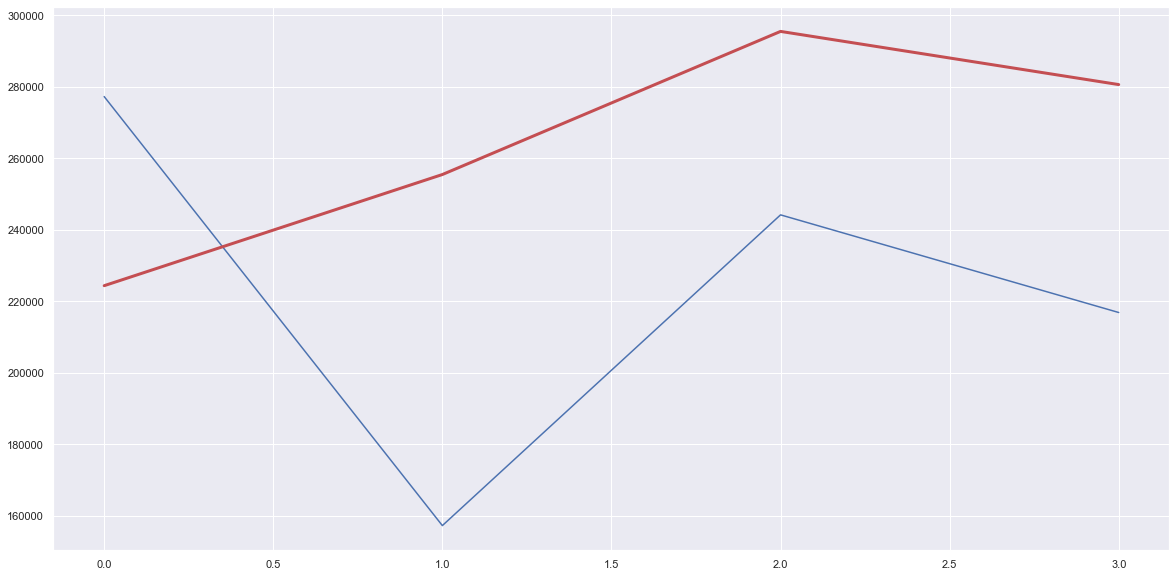

In [303]:
fig = plt.figure()
fig.set_size_inches(20,10)
plt.plot(range(X_pred['Year'].count()), np.expm1(y_pred))
plt.plot(range(X_pred['Year'].count()), np.expm1(y_pred2), c='r', linewidth=3)

In [82]:
dfr=pd.DataFrame()

In [83]:
dfr["real"]=y_test.values
dfr['predct'] = y_pred

In [84]:
dfr

,real,predct
0,122364.910000,156419.220484
1,179681.856133,98718.733737
2,135797.220000,193632.439531
3,41893.220000,75270.050549
4,104407.180000,110950.737614
...,...,...
61,236736.980000,169491.989178
62,103970.730000,83639.820688
63,95888.540000,114202.648525
64,104196.640000,150369.436438


In [410]:
kf = KFold(n_splits=5)

In [414]:
cross_val_score(reg,X,y,cv=10,scoring="r2")

array([ -0.84639769, -28.01207974,   0.35154528,  -1.10986955,
         0.82108121,  -1.11790739,   0.88359317,   0.80537493,
        -0.46556121,   0.77088949])

In [143]:
#Make a copy of the main dataframe
data = new_data[['Program','Year','Month','Day','Visits','Revenue']]

In [8]:
#For this early stage I discard type of Traffic and just sum all of them
data = data.groupby(['Year','Month','Day'])[['Visits','Revenue']].sum()

In [9]:
#Reset Index after having made a groupby
data = data.reset_index()

In [10]:
#Lets check it out how this looks like and we can see that we have 2223 rows of data. Original one was 100,033 rows
data

,Year,Month,Day,Visits,Revenue
0,2015,1,1,3834,3244.55
1,2015,1,2,6189,4791.64
2,2015,1,3,5523,534.93
3,2015,1,4,5086,848.43
4,2015,1,5,6185,2393.52
...,...,...,...,...,...
2218,2021,1,27,39461,36720.96
2219,2021,1,28,41043,30386.56
2220,2021,1,29,39174,65198.11
2221,2021,1,30,29582,33134.80


Let's check the Variability of Pearson
 * High Variability in Revenue
 * Visit Variability is less than Revenue but it is above 0.5


In [11]:
#High Variability in Revenue
pearson_revenue = data['Revenue'].std() / data['Revenue'].mean()
#Visit Variability is less than Revenue but it is above 0.5
pearson_traffic = data['Visits'].std() / data['Visits'].mean()
print(f'Pearson Revenue: {pearson_revenue}) and Pearson Visits: {pearson_traffic}')

Pearson Revenue: 1.53995483973178) and Pearson Visits: 0.6361548377691404


In [12]:
data['Revenue'].describe()

count      2223.000000
mean      25438.899731
std       39174.756758
min           0.000000
25%        9351.615000
50%       18048.570000
75%       31929.080000
max      858333.560000
Name: Revenue, dtype: float64

In [13]:
#There are number way above 100.000. Those are some outliners
sorted(data['Revenue'], reverse=True)

[858333.5600000034,
 784321.290000003,
 590327.1899999998,
 563812.3999999989,
 529061.6699999995,
 334605.57000000076,
 311593.59999999957,
 304644.9999999996,
 206742.70999999996,
 192917.33000000007,
 191231.44000000012,
 187432.28999999983,
 186791.86000000004,
 171407.57999999987,
 169560.74000000005,
 167811.78999999986,
 153453.7500000001,
 139222.25999999998,
 132259.49000000002,
 132244.95,
 131383.15999999992,
 130645.76999999989,
 124783.69999999997,
 124024.70000000022,
 117069.57999999999,
 115680.39000000003,
 112899.65000000001,
 111940.03999999998,
 109272.9500000002,
 107702.02999999996,
 107599.70999999995,
 104098.95000000004,
 101380.1800000001,
 100517.25999999995,
 98058.94000000002,
 97243.22999999998,
 95266.08000000016,
 94826.27,
 93087.03000000006,
 92653.50999999995,
 92156.65000000002,
 91074.79,
 90887.97000000009,
 90056.15,
 89374.43000000004,
 88473.35000000008,
 87368.04000000008,
 86168.33999999995,
 84098.13000000002,
 83723.62,
 82678.79,
 81664.65,

(array([ 54., 100., 120., 154., 177., 143., 126., 110., 124., 115.,  95.,
         81.,  79.,  63.,  61.,  66.,  61.,  51.,  55.,  41.,  35.,  26.,
         35.,  34.,  32.,  13.,  15.,  17.,  11.,  10.,  14.,   9.,   6.,
         13.,   2.,   6.,   5.,   4.,   5.,   1.,   3.,   2.,   1.,   2.,
          2.,   3.,   3.,   2.,   1.]),
 array([    0,  2000,  4000,  6000,  8000, 10000, 12000, 14000, 16000,
        18000, 20000, 22000, 24000, 26000, 28000, 30000, 32000, 34000,
        36000, 38000, 40000, 42000, 44000, 46000, 48000, 50000, 52000,
        54000, 56000, 58000, 60000, 62000, 64000, 66000, 68000, 70000,
        72000, 74000, 76000, 78000, 80000, 82000, 84000, 86000, 88000,
        90000, 92000, 94000, 96000, 98000]),
 <BarContainer object of 49 artists>)

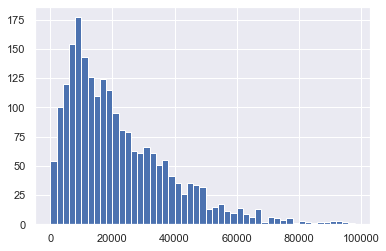

In [14]:
plt.hist(data['Revenue'], bins=range(0,100000,2000))

(array([3., 3., 2., 2., 2., 0., 4., 1., 0., 0., 1., 0., 0., 2., 1., 0., 0.,
        2., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([100000, 105000, 110000, 115000, 120000, 125000, 130000, 135000,
        140000, 145000, 150000, 155000, 160000, 165000, 170000, 175000,
        180000, 185000, 190000, 195000, 200000, 20

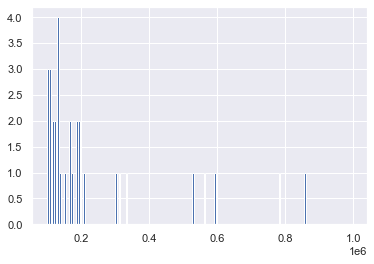

In [15]:
#Let's see the outliners
plt.hist(data['Revenue'], bins=range(100000,1000000,5000))

In [16]:
#We have 34 outliners out of more than 2000 records
data[data['Revenue'] > 100000]['Revenue'].value_counts().sum()

34

In [17]:
data['Visits'].describe()

count      2223.000000
mean      12871.529015
std        8188.285452
min         245.000000
25%        7774.000000
50%        9969.000000
75%       14886.000000
max      109148.000000
Name: Visits, dtype: float64

In [18]:
data['Visits'].max()

109148

(array([  1.,   9., 159., 449., 501., 309., 190.,  92.,  84.,  88.,  77.,
         48.,  55.,  28.,  25.,  31.,  10.,  10.,   7.,   9.,  15.,  11.,
          6.,   2.,   2.,   1.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.]),
 array([    0,  2000,  4000,  6000,  8000, 10000, 12000, 14000, 16000,
        18000, 20000, 22000, 24000, 26000, 28000, 30000, 32000, 34000,
        36000, 38000, 40000, 42000, 44000, 46000, 48000, 50000, 52000,
        54000, 56000, 58000, 60000, 62000, 64000, 66000, 68000, 70000,
        72000, 74000, 76000, 78000, 80000, 82000, 84000, 86000, 88000,
        90000, 92000, 94000, 96000, 98000]),
 <BarContainer object of 49 artists>)

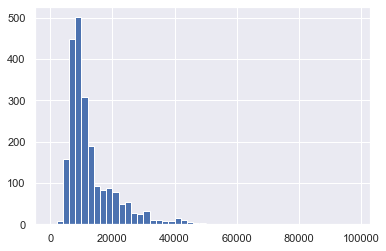

In [19]:
plt.hist(data['Visits'], bins=range(0,100000,2000))

In [20]:
#Let's see the correlation across the variables
data.corr()

,Year,Month,Day,Visits,Revenue
Year,1.000000,-0.044018,0.001226,0.659991,0.305776
Month,-0.044018,1.000000,0.009158,0.168876,0.128174
Day,0.001226,0.009158,1.000000,0.074226,0.088392
Visits,0.659991,0.168876,0.074226,1.000000,0.591148
Revenue,0.305776,0.128174,0.088392,0.591148,1.000000


In [21]:
#Now let's try to apply log to the variables, except when the value is 0 (inf.)
data_log = pd.DataFrame(np.log(data[data['Revenue'] != 0]))

In [22]:
#Now we can see a different correlation matrix. Visits still quite correlate with Revenue but Year as well
data_log.corr()

,Year,Month,Day,Visits,Revenue
Year,1.000000,-0.063566,0.001097,0.732171,0.604629
Month,-0.063566,1.000000,0.005938,0.092400,0.109626
Day,0.001097,0.005938,1.000000,0.054783,0.076481
Visits,0.732171,0.092400,0.054783,1.000000,0.675325
Revenue,0.604629,0.109626,0.076481,0.675325,1.000000


In [23]:
#Bear in mind that we are using Log e and therefore Pearson results are different
pearson_revenue = data_log['Revenue'].std() / data_log['Revenue'].mean()
pearson_traffic = data_log['Visits'].std() / data_log['Visits'].mean()
print(f'Pearson Revenue: {pearson_revenue} and Pearson Visits: {pearson_traffic}')

Pearson Revenue: 0.09859521582003562 and Pearson Visits: 0.05443959700737877


In [24]:
data_log['Revenue'].describe()

count    2217.000000
mean        9.720446
std         0.958389
min         3.837730
25%         9.153696
50%         9.804346
75%        10.374114
max        13.662748
Name: Revenue, dtype: float64

(array([  0.,   0.,   0.,   2.,   1.,   1.,   1.,   0.,   0.,   0.,   1.,
          0.,   3.,   0.,   2.,   1.,   4.,   5.,   6.,  12.,  18.,  29.,
         35.,  52.,  59., 111., 134., 174., 176., 207., 244., 204., 212.,
        208., 143.,  79.,  41.,  20.,  10.,   6.,   7.,   1.,   2.,   1.,
          0.,   3.,   0.,   2.,   0.]),
 array([ 3.        ,  3.2244898 ,  3.44897959,  3.67346939,  3.89795918,
         4.12244898,  4.34693878,  4.57142857,  4.79591837,  5.02040816,
         5.24489796,  5.46938776,  5.69387755,  5.91836735,  6.14285714,
         6.36734694,  6.59183673,  6.81632653,  7.04081633,  7.26530612,
         7.48979592,  7.71428571,  7.93877551,  8.16326531,  8.3877551 ,
         8.6122449 ,  8.83673469,  9.06122449,  9.28571429,  9.51020408,
         9.73469388,  9.95918367, 10.18367347, 10.40816327, 10.63265306,
        10.85714286, 11.08163265, 11.30612245, 11.53061224, 11.75510204,
        11.97959184, 12.20408163, 12.42857143, 12.65306122, 12.87755102,
       

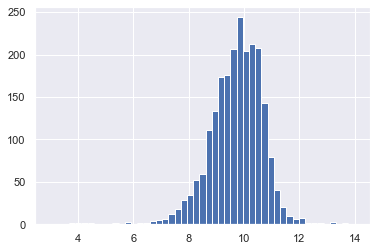

In [25]:
plt.hist(data_log['Revenue'], bins=np.linspace(start=3,stop=14,num=50))

In [26]:
data_log['Visits'].describe()

count    2217.000000
mean        9.320332
std         0.507395
min         8.148156
25%         8.960468
50%         9.208238
75%         9.609787
max        11.600460
Name: Visits, dtype: float64

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          4.,   7.,  12.,  38.,  66.,  67., 110., 195., 215., 217., 251.,
        180., 131., 122.,  71.,  66.,  87.,  86.,  66.,  63.,  37.,  48.,
         14.,  19.,  26.,  12.,   4.,   1.,   0.,   0.,   1.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.]),
 array([ 7.        ,  7.10204082,  7.20408163,  7.30612245,  7.40816327,
         7.51020408,  7.6122449 ,  7.71428571,  7.81632653,  7.91836735,
         8.02040816,  8.12244898,  8.2244898 ,  8.32653061,  8.42857143,
         8.53061224,  8.63265306,  8.73469388,  8.83673469,  8.93877551,
         9.04081633,  9.14285714,  9.24489796,  9.34693878,  9.44897959,
         9.55102041,  9.65306122,  9.75510204,  9.85714286,  9.95918367,
        10.06122449, 10.16326531, 10.26530612, 10.36734694, 10.46938776,
        10.57142857, 10.67346939, 10.7755102 , 10.87755102, 10.97959184,
        11.08163265, 11.18367347, 11.28571429, 11.3877551 , 11.48979592,
       

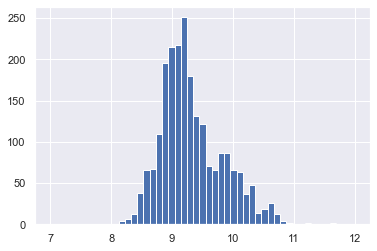

In [27]:
plt.hist(data_log['Visits'], bins=np.linspace(start=7,stop=12,num=50))

In [28]:
#This is a new DataFrame 
data_by_year_month = data.groupby(['Year','Month'])[['Visits','Revenue']].sum()
data_by_year_month = data_by_year_month.reset_index()

In [29]:
def back_poly_parameters(l,i,x):
    """
    DESCRIPTION
      This function return a vector of coefficients for plotting easily. It is using backtracking
    ARGUMENTS
      l: list of coefficients from np.polyfit, it does not matter the degree
      i: This is the len of the list
      x: It is the X parameter
    RETURN
      A value p[0] * x**deg + ... + p[deg]
    """
    if i == 0:
        return 0
    else:
        #Empiezo de atrás hacia adelante porque el primer polinomio es x^y...hasta b
        #Si el índice tiene 3 elementos entonces x²+x+b y así sucesivamente
        return l[-i]*x**(i-1) + back_poly_parameters(l,i-1,x)

In [43]:
x = data_by_year_month.index
#Lets prepare a polynomial regression line for Revenue
y_revenue = data_by_year_month['Revenue']
d_r = 4 #This is the degree for the polynomial
list_revenue = np.polyfit(x, y_revenue, d_r)

#Lets prepare a polynomial regression line for Revenue
y_visits = data_by_year_month['Visits']
d_v = 4 #This is the degree for the polynomial
list_visits = np.polyfit(x, y_visits, d_v)

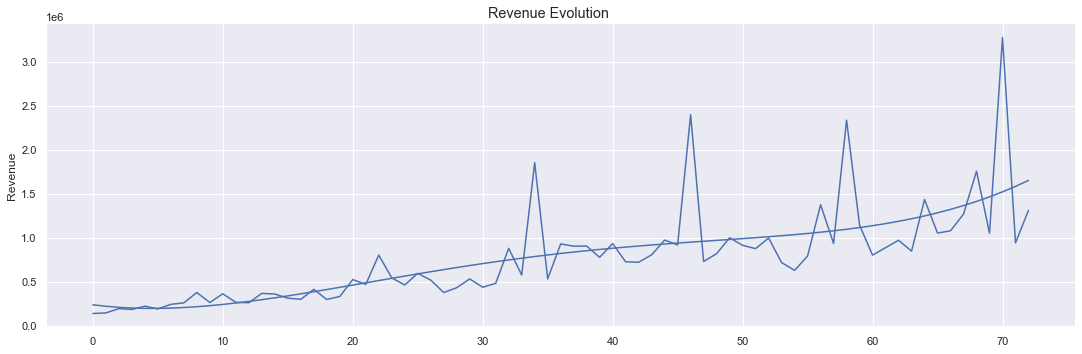

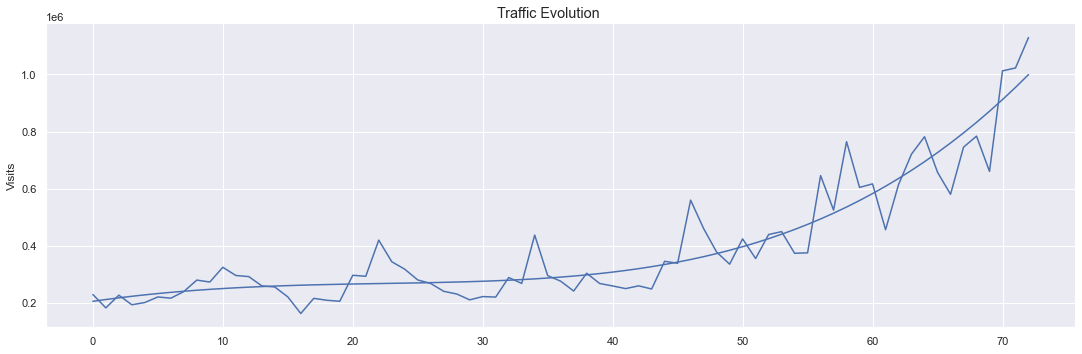

In [44]:
#Here we can see the trend across the months in Revenue and Visits and we draw another line.
#Actually that line is a polynomial line, in the Revenue case, it is a pure line because degree=2 does not
#Show any difference. However, the Visits chart is adjusting much better with a degree=2 or even 3
g = sns.relplot(data=data_by_year_month, x=data_by_year_month.index, y='Revenue', kind='line', aspect=3).fig.suptitle('Revenue Evolution')
plt.plot(x, back_poly_parameters(list_revenue, len(list_revenue), x))
#plt.axvline(100, color="r", linestyle="--");
sns.relplot(data=data_by_year_month, x=data_by_year_month.index, y='Visits', kind='line', aspect=3).fig.suptitle('Traffic Evolution')
plt.plot(x, back_poly_parameters(list_visits, len(list_visits), x))

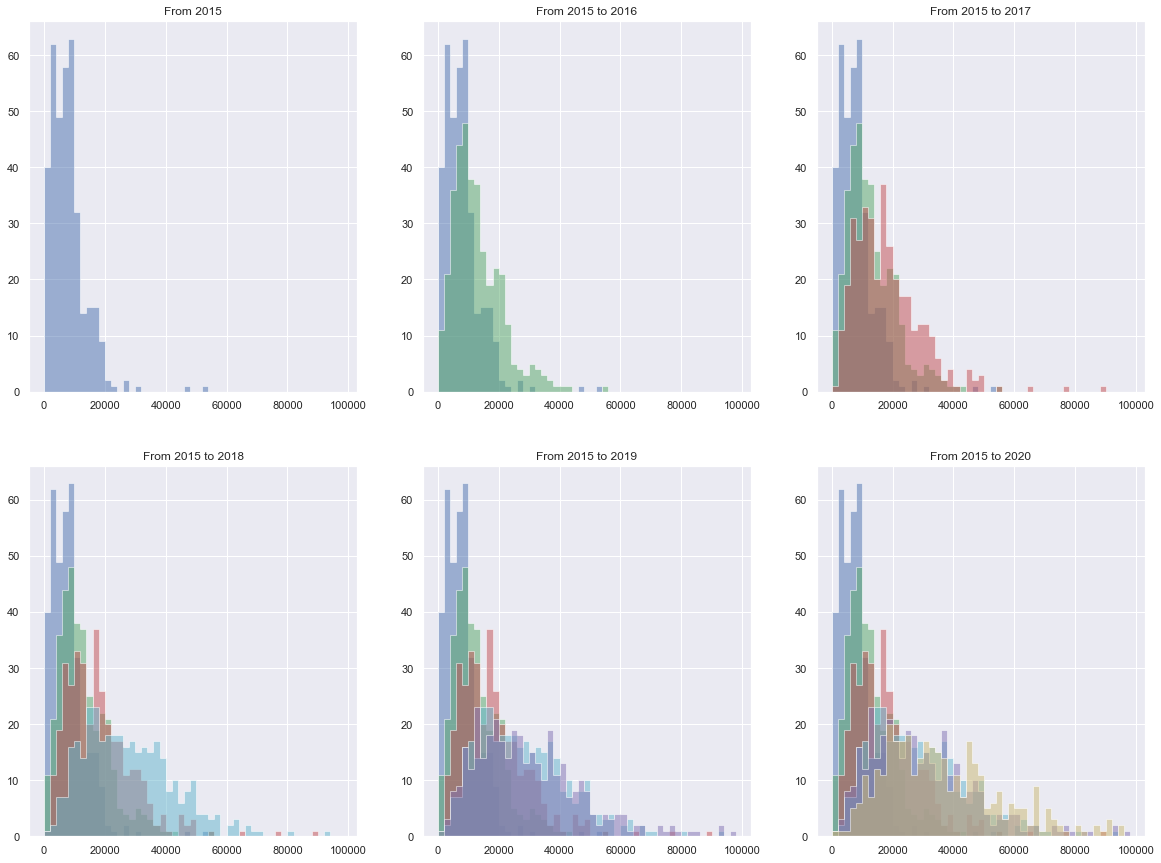

In [32]:
#It seems the Revenue distribution follows a Gamma Distribution even when you add the rest of the years
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(20, 15)
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

def draw_hist(df, col, col_con, lista ,ax):
    m = 0
    k = 0
    for i in range(len(ax)):
        for j in range(len(ax[i])):
            while k <= m:
                ax[i,j].hist(df[df[col_con] == lista[k]][col], bins=range(0,100000,2000), color=colors[k], histtype='stepfilled', alpha=0.5)
                k += 1
            title = 'From ' + str(lista[m])
            if m > 0:
                title = 'From ' + str(lista[0]) + ' to ' + str(lista[m])
            ax[i,j].set(title=title)
            k = 0
            m += 1
            
draw_hist(data, 'Revenue', 'Year', data['Year'].unique(), ax)

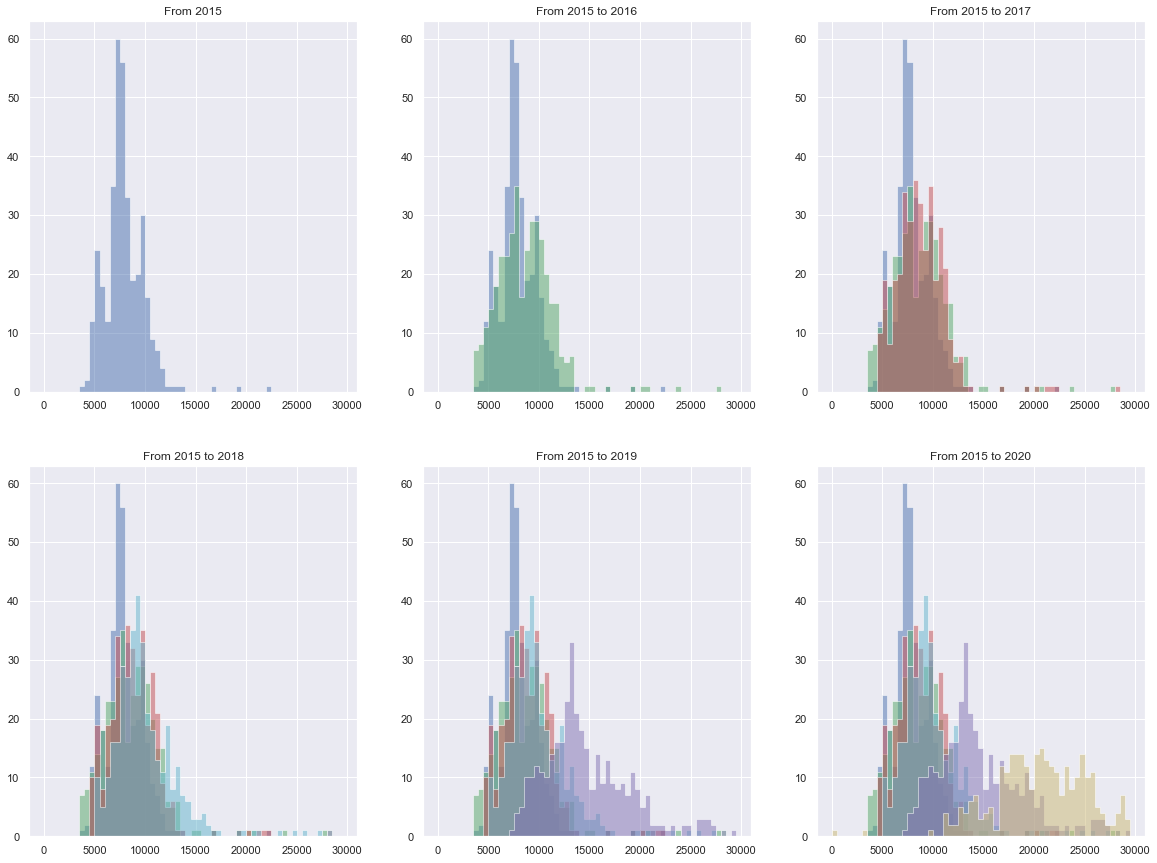

In [33]:
#Traffic seems a Norm Distribution but when you add more years it seems a Gamma Distribution but every year
#Seems centrated. Further analysis are needed
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(20, 15)
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

def draw_hist(df, col, col_con, lista ,ax):
    m = 0
    k = 0
    for i in range(len(ax)):
        for j in range(len(ax[i])):
            while k <= m:
                ax[i,j].hist(df[df[col_con] == lista[k]][col], bins=range(0,30000,500), color=colors[k], histtype='stepfilled', alpha=0.5)
                k += 1
            title = 'From ' + str(lista[m])
            if m > 0:
                title = 'From ' + str(lista[0]) + ' to ' + str(lista[m])
            ax[i,j].set(title=title)
            k = 0
            m += 1
            
draw_hist(data, 'Visits', 'Year', data['Year'].unique(), ax)

In [34]:
np.median(data['Revenue'])

18048.57

In [35]:
np.mean(data['Revenue'])

25438.899730604302

In [36]:
data['Revenue'].kurtosis()

206.35291518972994

In [37]:
data['Visits'].kurtosis()
#Leptocurtica

12.811651479904462

In [38]:
data['Revenue'].skew()
#Asimétrica a la derecha

12.066027764425613

In [39]:
data['Visits'].skew()

2.5753619816927293

In [40]:
from sklearn.metrics import r2_score